# Installing h3 Lib

In [1]:
!pip install ../input/h3lib/h3-3.7.4-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

Processing /kaggle/input/h3lib/h3-3.7.4-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl


# Limporting lib

In [2]:
import difflib
from h3 import h3
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from unidecode import unidecode
from tqdm.notebook import tqdm

tqdm.pandas()
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/h3lib/h3-3.7.4-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
/kaggle/input/foursquare-location-matching/sample_submission.csv
/kaggle/input/foursquare-location-matching/pairs.csv
/kaggle/input/foursquare-location-matching/train.csv
/kaggle/input/foursquare-location-matching/test.csv


# Data importing (train and test sets)

In [3]:
df_train = pd.read_csv('/kaggle/input/foursquare-location-matching/train.csv')
training_set_ = df_train.copy()

df_test = pd.read_csv('/kaggle/input/foursquare-location-matching/test.csv')
test_set_ = df_test.copy()

# Data first check

In [4]:
training_set_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1138812 entries, 0 to 1138811
Data columns (total 13 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   id                 1138812 non-null  object 
 1   name               1138811 non-null  object 
 2   latitude           1138812 non-null  float64
 3   longitude          1138812 non-null  float64
 4   address            742191 non-null   object 
 5   city               839623 non-null   object 
 6   state              718226 non-null   object 
 7   zip                543386 non-null   object 
 8   country            1138801 non-null  object 
 9   url                267724 non-null   object 
 10  phone              342855 non-null   object 
 11  categories         1040505 non-null  object 
 12  point_of_interest  1138812 non-null  object 
dtypes: float64(2), object(11)
memory usage: 112.9+ MB


In [5]:
missing = training_set_.isna().sum()
missing

id                        0
name                      1
latitude                  0
longitude                 0
address              396621
city                 299189
state                420586
zip                  595426
country                  11
url                  871088
phone                795957
categories            98307
point_of_interest         0
dtype: int64

In [6]:
# normalizing name to avoid mismatch due to accents or punctuations
training_set_['name'] = training_set_['name'].astype(str)
training_set_['name'] = training_set_['name'].apply(unidecode)
training_set_['name'] = training_set_['name'].str.replace('[^\w\s]','')
training_set_['name'] = training_set_['name'].str.lower()

test_set_['name'] = test_set_['name'].astype(str)
test_set_['name'] = test_set_['name'].apply(unidecode)
test_set_['name'] = test_set_['name'].str.replace('[^\w\s]','')
test_set_['name'] = test_set_['name'].str.lower()



# normalizing categories to avoid mismatch due to accents or punctuations
training_set_['categories'] = training_set_['categories'].astype(str)
training_set_['categories'] = training_set_['categories'].apply(unidecode)
training_set_['categories'] = training_set_['categories'].str.replace('[^\w\s]','')
training_set_['categories'] = training_set_['categories'].str.lower()

test_set_['categories'] = test_set_['categories'].astype(str)
test_set_['categories'] = test_set_['categories'].apply(unidecode)
test_set_['categories'] = test_set_['categories'].str.replace('[^\w\s]','')
test_set_['categories'] = test_set_['categories'].str.lower()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: The default value of regex will change from True to False in a future version.


# Data Exploration

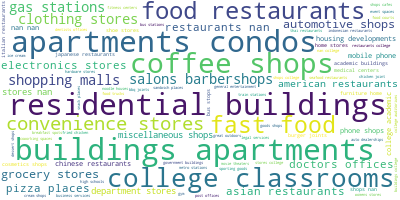

In [7]:
# Import the wordcloud library
from wordcloud import WordCloud # Join the different processed titles together.

long_string = ','.join(list(training_set_['categories'].values))# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color= 'steelblue')# Generate a word cloud
wordcloud.generate(long_string)# Visualize the word cloud
wordcloud.to_image()

# Feature Engineer

In [8]:
training_set_[training_set_['name'] == 'carioca manero']

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
1,E_000002eae2a589,carioca manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,brazilian restaurants,P_d82910d8382a83
1032766,E_e80db432029aea,carioca manero,-22.907025,-43.178067,Shopping Avenida Central,Rio de Janeiro,RJ,20040-901,BR,NaN,NaN,bars snack places,P_d82910d8382a83


## As we can see above, we have some duplicated entries that have different categories. As humans, we can see both of them are food places. So I need a way to reduce the number of categories to help the filter step. 
## So, considering the number of categories available, it was unviable to classify all of them by myself. After some research, I found the LDA method that allows to cluster of words into categories. (check: https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21).



In [9]:
import re
import unidecode

def tokenization(text):
    tokens = re.split(' ',text)
    return tokens

training_set_['category_tokenied']= training_set_['categories'].apply(lambda x: tokenization(x))
test_set_['category_tokenied']= test_set_['categories'].apply(lambda x: tokenization(x))

data = training_set_.category_tokenied.values.tolist()

In [10]:
import gensim.corpora as corpora # Create Dictionary

id2word = corpora.Dictionary(data) # Create Corpus

texts = data # Term Document Frequency

corpus = [id2word.doc2bow(text) for text in texts]# View

id2word

In [11]:
import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
id2word.save('dictionary.gensim')

In [12]:
import gensim
from gensim.utils import simple_preprocess
from pprint import pprint# number of topics

num_topics = 4 # from 3, 4, 5, 10 ,15 - 4 clusters was the one that was the best coherence

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=training_set_['category_tokenied'].tolist(), dictionary=lda_model.id2word, coherence='c_v')
with np.errstate(invalid='ignore'):
    lda_score = coherence_model_lda.get_coherence()

print(lda_score)

[(0,
  '0.182*"nan" + 0.094*"offices" + 0.062*"cafes" + 0.040*"hotels" + 0.038*"" + '
  '0.035*"salons" + 0.031*"college" + 0.028*"barbershops" + 0.027*"shopping" + '
  '0.026*"malls"'),
 (1,
  '0.094*"buildings" + 0.089*"stores" + 0.088*"" + 0.062*"college" + '
  '0.048*"food" + 0.037*"apartments" + 0.037*"condos" + 0.037*"residential" + '
  '0.032*"classrooms" + 0.025*"fast"'),
 (2,
  '0.206*"restaurants" + 0.086*"stores" + 0.035*"banks" + 0.030*"places" + '
  '0.029*"bars" + 0.027*"centers" + 0.026*"convenience" + 0.017*"hospitals" + '
  '0.016*"pizza" + 0.016*"spaces"'),
 (3,
  '0.186*"shops" + 0.060*"stations" + 0.044*"coffee" + 0.037*"schools" + '
  '0.025*"gas" + 0.022*"automotive" + 0.020*"other" + 0.020*"general" + '
  '0.020*"universities" + 0.019*"bus"')]
0.4516903589315179


In [13]:
print(lda_score)

0.4516903589315179


In [14]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/opt/conda/lib/python3.7/site-packages/past/types/oldstr.py:36: DeprecationWarning: invalid escape sequence \d
  """
/opt/conda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.170806 -0.074408       1        1  29.675700
2     -0.114338 -0.279286       2        1  26.511721
3      0.422739  0.007182       3        1  23.062245
0     -0.137595  0.346512       4        1  20.750334, topic_info=            Term           Freq          Total Category  logprob  loglift
2    restaurants  142873.000000  142873.000000  Default  30.0000  30.0000
8          shops  112949.000000  112949.000000  Default  29.0000  29.0000
31           nan   97854.000000   97854.000000  Default  28.0000  28.0000
11     buildings   72631.000000   72631.000000  Default  27.0000  27.0000
23       offices   50970.000000   50970.000000  Default  26.0000  26.0000
..           ...            ...            ...      ...      ...      ...
0           bars    9973.090236   30205.513165   Topic4  -3.9897   0.4645
44       centers    8332.604815   26762.355926   Topic4  -4.1694   0.4058
161           or    5597.645671   13158.105201   Topic4  -4.5672   0.7179
226       houses    4329.900133    8107.113333   Topic4  -4.8240   0.9454
51         rooms    4264.426813    8369.602995   Topic4  -4.8393   0.8983

[181 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
3         1  0.768256              
3         3  0.000158              
3         4  0.231587              
230       1  0.999925      academic
368       3  0.999904       airport
...     ...       ...           ...
249       1  0.999854        trucks
167       3  0.999933  universities
255       1  0.999923         video
110       1  0.000208        womens
110       2  0.999848        womens

[178 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 1])

## Let's check how to get the cluster from this model

In [15]:
dictionary = corpora.Dictionary(data)
new_doc = 'airport services'

def prepare_text_for_lda(text):
    tokens = tokenization(text)
    tokens = [token for token in tokens if len(token) > 4]
    return tokens

new_doc = prepare_text_for_lda(new_doc)
new_doc_bow = dictionary.doc2bow(new_doc)


print(new_doc_bow)
print(lda_model.get_document_topics(new_doc_bow))

[(189, 1), (368, 1)]
[(0, 0.08427587), (1, 0.08406967), (2, 0.08643633), (3, 0.74521816)]


## So get_document_topics returns a list of tuples with the percent of similarity with each cluster. Let's use it to apply for all the row by definig a function and them apply it. 

In [16]:
def get_lda_cluster(category):
    new_doc = prepare_text_for_lda(category)
    new_doc_bow = dictionary.doc2bow(new_doc)
    clusters = lda_model.get_document_topics(new_doc_bow)
    
    scores = []
    for i in clusters:
        scores.append(i[1])

    max_index = scores.index(max(scores))
    return clusters[max_index][0]
    

In [17]:
training_set_['category_cluster'] = training_set_.progress_apply(lambda x: get_lda_cluster(x['categories']),axis=1)

  0%|          | 0/1138812 [00:00<?, ?it/s]

In [18]:
test_set_['category_cluster'] = test_set_.progress_apply(lambda x: get_lda_cluster(x['categories']),axis=1)


  0%|          | 0/5 [00:00<?, ?it/s]

### My approach was using the h3 lib created by Uber (check documentation here: https://github.com/uber/h3) to cluster POIs into hex using the method h3.geo_to_h3 first. It will help us to check in a certain hex all the places.  
### It allows to search new POIs according the hex_cell id which combined to others features to solve eventually conflits, can solve this bussiness problem. 

In [19]:
training_set_.rename(columns = {'longitude': 'lng', 'latitude': 'lat'}, inplace = True)
test_set_.rename(columns = {'longitude': 'lng', 'latitude': 'lat'}, inplace = True)

## Creating the Hex_cell ids

In [20]:
H3_res = 9
def geo_to_h3(row):
  return h3.geo_to_h3(lat=row.lat,lng=row.lng,resolution = H3_res)

In [21]:
training_set_['h3_cell'] = training_set_.apply(geo_to_h3,axis=1)
test_set_['h3_cell'] = test_set_.progress_apply(geo_to_h3,axis=1)

  0%|          | 0/5 [00:00<?, ?it/s]

# Defining the search engine 

### Here I'm going to use all the features that I created to build a engine search. First i'm going to use the hex id to filter all the places of a certain area, than I will filter all of them by the category cluster. Than, to solve eventually conflits, I'm using the difflib.get_close_matches to get the most similar name str. 

In [22]:
def search_engine(id, name, h3_cell, cluster):
    first_step = training_set_[training_set_['h3_cell'] == h3_cell]
    second_step = first_step[training_set_['category_cluster'] == cluster]
    
    kw = difflib.get_close_matches(name, second_step['name'], n=3)
    
    result = second_step[second_step['name'].isin(kw)]
    if result['id'].empty:
        return id
    else:
        sep = ' '
        match_formated = id
        for match in result['id']:
            match_formated += sep 
            match_formated += match
        return match_formated

In [23]:
test_set_['matches'] = test_set_.apply(lambda x: search_engine(x['id'], x['name'], x['h3_cell'], x['category_cluster']),axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
test_set_

,id,name,lat,lng,address,city,state,zip,country,url,phone,categories,category_tokenied,category_cluster,h3_cell,matches
0,E_00001118ad0191,jamu petani bagan serai,5.012169,100.535805,NaN,NaN,NaN,NaN,MY,NaN,NaN,cafes,[cafes],0,8965032cc53ffff,E_00001118ad0191 E_5be051889de601
1,E_000020eb6fed40,johnnys bar,40.434209,-80.564160,497 N 12th St,Weirton,WV,26062.0,US,NaN,NaN,bars,[bars],0,892a86a3457ffff,E_000020eb6fed40
2,E_00002f98667edf,qiwi,47.215134,39.686088,"Межевая улица, 60",Ростов-на-Дону,NaN,NaN,RU,https://qiwi.com,7.800301e+10,atms,[atms],0,892d440ee4bffff,E_00002f98667edf
3,E_001b6bad66eb98,gelora sriwijaya jaka baring sport city,-3.014675,104.794374,NaN,NaN,NaN,NaN,ID,NaN,NaN,stadiums,[stadiums],3,898cab70a37ffff,E_001b6bad66eb98 E_161706a74b5308
4,E_0283d9f61e569d,stadion gelora sriwijaya,-3.021727,104.788628,Jalan Gubernur Hasan Bastari,Palembang,South Sumatra,11480.0,ID,NaN,NaN,soccer stadiums,"[soccer, stadiums]",3,898cab70bd7ffff,E_0283d9f61e569d E_6e477dd29c2dc2


In [25]:
training_set_[training_set_['id'] == 'E_161706a74b5308']

,id,name,lat,lng,address,city,state,zip,country,url,phone,categories,point_of_interest,category_tokenied,category_cluster,h3_cell
98575,E_161706a74b5308,gelora sriwijaya jaka baring sport city,-3.014675,104.794374,NaN,NaN,NaN,NaN,ID,NaN,NaN,stadiums,P_3a29d96ec6eb0c,[stadiums],3,898cab70a37ffff


In [26]:
training_set_[training_set_['id'] == 'E_6e477dd29c2dc2']

,id,name,lat,lng,address,city,state,zip,country,url,phone,categories,point_of_interest,category_tokenied,category_cluster,h3_cell
490551,E_6e477dd29c2dc2,stadion gelora sriwijaya,-3.021727,104.788628,Jalan Gubernur Hasan Bastari,Palembang,South Sumatra,11480,ID,NaN,NaN,soccer stadiums,P_3a29d96ec6eb0c,"[soccer, stadiums]",3,898cab70bd7ffff


## As we can see, it was enough to find a pretty good match for two of 5 rows of the sample

In [27]:
submission_sample = test_set_[['id','matches']]


In [28]:
submission_sample

,id,matches
0,E_00001118ad0191,E_00001118ad0191 E_5be051889de601
1,E_000020eb6fed40,E_000020eb6fed40
2,E_00002f98667edf,E_00002f98667edf
3,E_001b6bad66eb98,E_001b6bad66eb98 E_161706a74b5308
4,E_0283d9f61e569d,E_0283d9f61e569d E_6e477dd29c2dc2


# Sample Submittion

In [29]:
submission_sample.to_csv('/kaggle/working/submission.csv')